# Breast Cancer Proteomes

The dataset contains published iTRAQ proteome profiling of 77 breast cancer samples generated by the Clinical Proteomic Tumor Analysis Consortium (NCI/NIH). It contains expression values for ~12.000 proteins for each sample, with missing values present when a given protein could not be quantified in a given sample.


###### AIM:
To build ML models to predict various endpoints like AJCC stage, metastasis, tumor stage and PAM50 mRNA type

In [2]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder , MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score

Preprocessing the dataset to combine target endpoint from TCGA metadata with proteome data

In [8]:
data = pd.read_csv("77_cancer_proteomes_CPTAC_itraq.csv")
meta = pd.read_csv("clinical_data_breast_cancer.csv")

Selecting features that would be available for the model, and not features infered from other analysis because those might not be available outside the scope of TCGA. Hence aiming to make a generalized model.

In [9]:
meta = meta[['Complete TCGA ID', 'Gender', 'Age at Initial Pathologic Diagnosis',
       'ER Status', 'PR Status', 'HER2 Final Status', 'Tumor',
       'Metastasis-Coded', 'AJCC Stage','PAM50 mRNA']] 

In [10]:
data.drop(["gene_name"],inplace=True,axis=True)

In [11]:
idtcga=[]
for i in data.T.index[2:82].tolist():
    idtcga.append(i.split(".")[0])

In [12]:
metaid=[]
for i in meta["Complete TCGA ID"].unique():
    metaid.append(i[5:])

In [13]:
meta["Complete TCGA ID"] = metaid
meta = meta[meta["Complete TCGA ID"].isin(idtcga)]
data1 =  data.T
data1.reset_index(inplace=True)
data1.columns = data1.iloc[0]
data1 = data1.iloc[2:,:]

In [14]:
idlist=[]
for i in data1["RefSeq_accession_number"]:
    idlist.append(i.split(".")[0])

In [15]:
data1["RefSeq_accession_number"] = idlist
data1 = data1[data1["RefSeq_accession_number"].isin(idtcga)]
data1.sort_values(by="RefSeq_accession_number",inplace=True)
data1.drop_duplicates("RefSeq_accession_number",inplace=True)
nancount = pd.DataFrame({"count":data1.isnull().sum()/77})
data2 = data1[nancount[nancount["count"]==0].index.tolist()]
meta.rename(columns={'Complete TCGA ID': 'RefSeq_accession_number'}, inplace=True)

In [16]:
for c in meta.columns:
    if meta[c].dtype=="object" and c!="RefSeq_accession_number":
        label_encoder = LabelEncoder()
        meta[c] = label_encoder.fit_transform(meta[c])

In [17]:
final = pd.merge(meta,data2,on=["RefSeq_accession_number"],how="right")

In [18]:
final.to_csv("final_data.csv",index=False) #checkpoint1

Saved the cleaned dataset for Model training

### Model training - AJCC stage

Prediction of AJCC Stage

In [19]:
final = pd.read_csv("final_data.csv")

Removing other targets endpoints and sample id

In [20]:
final.drop(['RefSeq_accession_number','Metastasis-Coded','PAM50 mRNA','Tumor',"ER Status","PR Status","HER2 Final Status"],axis=True,inplace=True)

Removing sample with stage 10 as only one sample has stage labeled as 10, which is not enough

In [21]:
final = final[final["AJCC Stage"]!=10] 

Finding corelation between "ajcc stage" and other features and filtering out features that have low correlation for better learning

In [22]:
x = pd.DataFrame(abs(final.corr()["AJCC Stage"]))
final2 = final[x[x["AJCC Stage"]>0.2].index.tolist()] #keeping features above 0.2 corelation

In [23]:
final2.columns

Index(['AJCC Stage', 'NP_003118', 'NP_001123910', 'NP_001182461', 'NP_003119',
       'NP_842565', 'NP_055874', 'NP_612482', 'NP_006827', 'NP_003080',
       ...
       'NP_000945', 'NP_071390', 'NP_067041', 'NP_008955', 'NP_001123990',
       'NP_005728', 'NP_932348', 'NP_037519', 'NP_065083', 'NP_065775'],
      dtype='object', length=600)

Only 599 proteins were left after the correlation filter

#### Scaling

In [89]:
scaler = MinMaxScaler() #scaling
final2_scale = pd.DataFrame(scaler.fit_transform(final2.drop('AJCC Stage', axis=1)),columns=final2.columns.to_list()[1:])

In [91]:
X = final2_scale
y = final2['AJCC Stage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)

In [97]:
#XGB

In [92]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [96]:
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 43.48


In [93]:
idx = xgb.feature_importances_.argsort()

<BarContainer object of 50 artists>

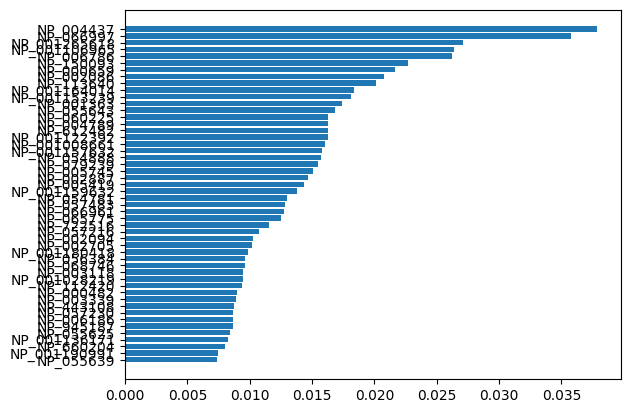

In [94]:
plt.barh(X_train.columns[idx][549:599],xgb.feature_importances_[idx][549:599])

In [95]:
X_train.columns[idx][549:599]

Index(['NP_055639', 'NP_001190991', 'NP_660204', 'NP_001136171', 'NP_055625',
       'NP_945187', 'NP_006186', 'NP_057230', 'NP_443108', 'NP_003339',
       'NP_000482', 'NP_112420', 'NP_001028219', 'NP_003118', 'NP_068746',
       'NP_056384', 'NP_001180418', 'NP_002705', 'NP_002094', 'NP_057216',
       'NP_722516', 'NP_065775', 'NP_066961', 'NP_057483', 'NP_054781',
       'NP_001159632', 'NP_005419', 'NP_002887', 'NP_005745', 'NP_079239',
       'NP_054888', 'NP_001157632', 'NP_001008661', 'NP_001122392',
       'NP_612482', 'NP_004789', 'NP_060225', 'NP_055643', 'NP_001363',
       'NP_001153239', 'NP_001164014', 'NP_113640', 'NP_002086', 'NP_000659',
       'NP_150093', 'NP_006786', 'NP_001106965', 'NP_001265618', 'NP_066997',
       'NP_004437'],
      dtype='object')

No protein has good enough importance for the model. Taking top 50 importemt proteins for pathway enrichment did not result in any significant pathway enrichment.  
Showing that the data is not good enough for AJCC stage prediction using XGB model

### Model training - Metastasis

In [3]:
final = pd.read_csv("final_data.csv")

Prediction of Metastasis-Coded

In [4]:
final.drop(['RefSeq_accession_number','PAM50 mRNA','Tumor','AJCC Stage',"ER Status","PR Status","HER2 Final Status"],axis=True,inplace=True) #removing other targets and sample id

Finding corelation between "Metastasis-Coded" and other features and filtering out features that have low correlation for better learning

In [5]:
#corelation with the target "Metastasis-Coded"
x = pd.DataFrame(abs(final.corr()["Metastasis-Coded"]))

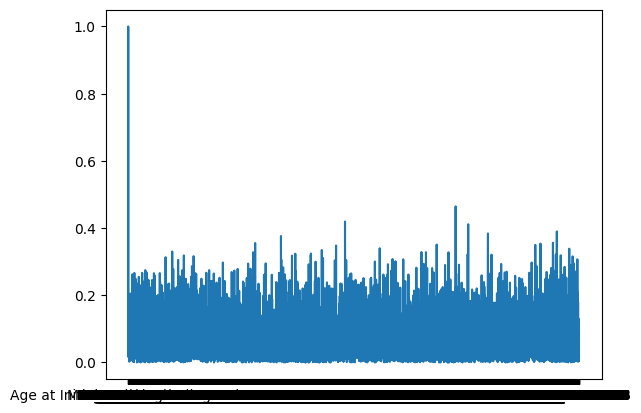

In [6]:
plt.plot(x)

In [7]:
x[x["Metastasis-Coded"]>0.2].shape

(444, 1)

Only 444 proteins were left after the correlation filter

In [8]:
final2 = final[x[x["Metastasis-Coded"]>0.2].index.tolist()] #keeping features above 0.2 corelation, 444 proteins 

In [9]:
scaler = MinMaxScaler() #scaling
final2_scale = pd.DataFrame(scaler.fit_transform(final2.drop('Metastasis-Coded', axis=1)),columns=final2.columns.to_list()[1:])

In [10]:
X = final2_scale
y = final2['Metastasis-Coded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 100.00


<BarContainer object of 5 artists>

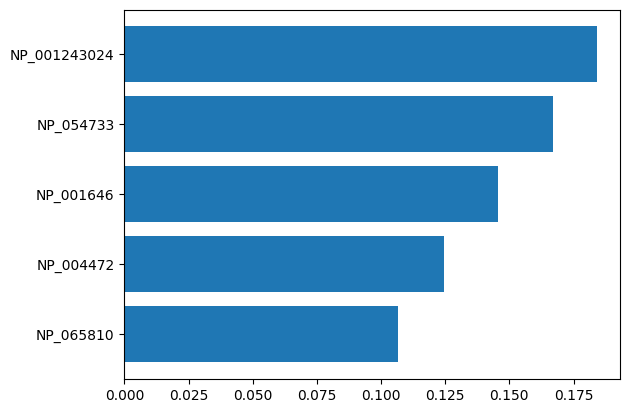

In [20]:
idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[idx][438:444],xgb.feature_importances_[idx][438:444]) #top5

In [18]:
X_train.columns[idx][438:444] #top5 proteins in feature importance

Index(['NP_065810', 'NP_004472', 'NP_001646', 'NP_054733', 'NP_001243024'], dtype='object')

Protein here has good enough importance for the model (>0.1 importance seems to be great given 444 proteins given to the model to train on).   
Taking proteins which has importance more then 0.1 for pathway enrichment: Two pathways were significantly enriched (Enrichment FDR > 0.05)  
1. Mucin type O-glycan biosynthesis
2. Other types of O-glycan biosynthesis  
<br>
<br>
<br>

Mucin-type O-glycosylation is a common post-translational modification process of proteins, whose normal biosynthesis is inextricably linked to the maintenance of organismal health, and which is involved in various biological processe.  
In contrast, aberrant Oglycosylation is frequently accompanied by several diseases such as tumors, including the production of tumor-associated antigens. Tn, STn, and T antigen, and alterations in the activity or localization of some glycosyltransferases, are closely associated with tumor development; it has been well established that these alterations can modulate a range of malignant phenotypes of tumor cells and lead to reduced patient survival by inhibiting or activating signaling pathways.thways.)

## PC analysis

In [51]:
pca = PCA(n_components=1,random_state=42)
r = pca.fit_transform(X = X_train.values)
X_train_pca = pd.DataFrame(pca.transform(X_train.values))
print(X_train.shape, X_train_pca.shape)

xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train_pca, y_train)

X_test_pca = pca.transform(X_test)

preds = xgb.predict(X_test_pca)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))
print(confusion_matrix(y_test, preds))

(106, 443) (106, 1)
XGBoost's prediction accuracy is: 100.00
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
[[20  0]
 [ 0 26]]


C:\Users\shasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


A single principle component is good enough to differentiate the catagories.

In [57]:
#weights used for each feature to get the PC

In [52]:
component_weights = pca.components_
feature_names = X_train.columns

In [60]:
feature_weights_mapping = {}
for i, component in enumerate(component_weights):
  component_feature_weights = zip(feature_names, component)
  sorted_feature_weight = sorted(
      component_feature_weights, key=lambda x: abs(x[1]), reverse=True)
  feature_weights_mapping[f"Component {i+1}"] = sorted_feature_weight

In [61]:
val = []
protein=[]
for i in feature_weights_mapping.values():
    for j in i:
        protein.append(j[0])
        val.append(abs(j[1]))

<BarContainer object of 50 artists>

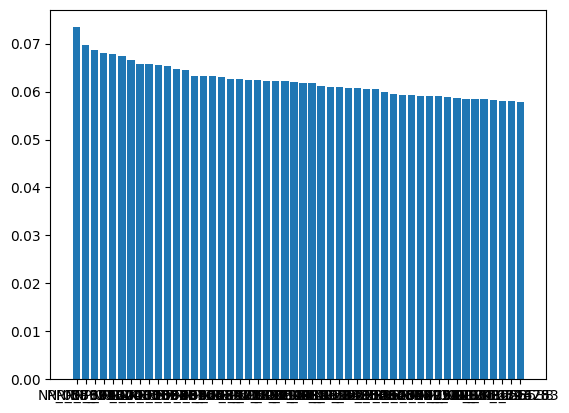

In [62]:
plt.bar(protein[:50],val[:50]) # top 50 protrein w.r.t weights used 

In [63]:
protein[:50] # top 50 protrein w.r.t weights used 

['NP_055321',
 'NP_056943',
 'NP_783322',
 'NP_003000',
 'NP_060200',
 'NP_001243657',
 'NP_004810',
 'NP_003332',
 'NP_006397',
 'NP_006348',
 'NP_006581',
 'NP_060670',
 'NP_689866',
 'NP_004542',
 'NP_652759',
 'NP_006347',
 'NP_003471',
 'XP_003960602',
 'NP_057132',
 'NP_003391',
 'NP_008879',
 'NP_001265443',
 'NP_116021',
 'NP_001008895',
 'NP_006209',
 'NP_001119526',
 'NP_001022',
 'NP_001119527',
 'NP_477352',
 'NP_958435',
 'NP_001258395',
 'NP_036340',
 'NP_001231634',
 'NP_932348',
 'NP_689485',
 'NP_057543',
 'NP_663722',
 'NP_056203',
 'NP_061924',
 'NP_941959',
 'NP_079120',
 'NP_054733',
 'NP_060936',
 'NP_001074002',
 'NP_001243655',
 'NP_060264',
 'NP_116313',
 'NP_001258538',
 'NP_079478',
 'NP_116253']

Performing pathway enrichment for the 50 proteins enriches few cell cycle based pathway alone with energy production related pathways, these are common enrichment pattern observed in cancer where cell cycle based and energy production pathways are over expressed.  

Although the most significantly enriched pathway is `Nucleocytoplasmic transport` which is metastasis specific pathway. Many papers have reportred the pathway playing crutial role in metastasis and has durgs in trails targeting to disrupt the pathway in cancer

#### Shortcomings: 
Although analysis on the data correlates with biology i.e., while enriching pathways with top contributing proteins results in pathway relavent to metastasis. But there is a huge class imbalance which is 76:1 leading to a model that is not robust enough. Possible way around might be fixing the class imbalance through over/under sampeling or SMOTE, but with only one sample in the particular class the sampling process won't have enough points for sampling and hence can not be reliable. 